### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL_Journal/BarbaraData_ANALYTICAL_Journal"
session_folder_name = abstracts_log_name.split('/')[-1]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[-1]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]18:3:12 Initiating the NLP Engine
[INFO]18:3:12 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL_Journal/BarbaraData_ANALYTICAL_Journal.txt is being ported to dataframe
[INFO]18:3:12 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL_Journal/BarbaraData_ANALYTICAL_Journal.txt has been ported to dataframe
[INFO]18:3:12 Trimming data and preparing list of words
[['A number of parasitic diseases have gained importance as neozoan opportunistic infections in the marine environment. Here, we report on the gastrointestinal endoparasite fauna of three baleen whale species and one toothed whale: blue (Balaenoptera musculus), fin (Balaenoptera physalus), and sei whales (Balaenoptera borealis) and sperm whales (Physeter macrocephalus) from the Azores Islands, Portugal. In total, 17 individual whale fecal samples [n=10 (B. physalus); n=4 (P. macrocephalus); n=2 (B. musculus); n=1 (B. borealis)] were collected from free-swimming animals as part of ong

[INFO]18:3:12 Generated word bigrams
[INFO]18:3:12 Beginning lemmatization
[INFO]18:3:13 Ending lemmatization
[INFO]18:3:15 Issued perplexity: -7.46736702632332
[INFO]18:3:15 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.014*"infection" + 0.012*"madv" + 0.011*"veev" + 0.009*"human" + 0.009*"cruzi" + 0.009*"lineage" + 0.007*"island" + 0.007*"sera" + 0.006*"risk" + 0.006*"mouse"'),
 (1,
  '0.018*"community" + 0.013*"peridomestic_setting" + 0.011*"andv" + 0.011*"transmission" + 0.010*"bat" + 0.009*"rodent" + 0.009*"macaque" + 0.009*"fly" + 0.008*"bacterial" + 0.007*"longicaudatus"'),
 (2,
  '0.009*"animal" + 0.009*"habitat" + 0.009*"whale" + 0.008*"possum" + 0.008*"sleep" + 0.008*"nest" + 0.008*"datum" + 0.006*"art" + 0.006*"forest" + 0.005*"disease"'),
 (3,
  '0.031*"host" + 0.028*"tick" + 0.010*"prevalence" + 0.010*"parasite" + 0.009*"rodent" + 0.009*"vector" + 0.009*"nymph" + 0.008*"distribution" + 0.008*"ectoparasite" + 0.008*"larvae"'),
 (4,
  '0.001*"host" + 0.001*"disease" + 0.001*"red" + 0.001*"squirrel" + 0.001*"tick" + 0.001*"pathogen" + 0.001*"animal" + 0.001*"mammal" + 0.000*"lyme" + 0.000*"colony"'),
 (5,
  '0.027*"host" + 0.015*"mammal" + 0.012*"human" + 0.011*"bat" + 0.011*"barton

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(1,
  [('tick', 0.10651499482936919),
   ('host', 0.07135470527404343),
   ('vector', 0.04343329886246122),
   ('rodent', 0.025853154084798345),
   ('number', 0.025853154084798345),
   ('distribution', 0.023784901758014478),
   ('chigger', 0.02171664943123061),
   ('feed', 0.01861427094105481),
   ('ixode', 0.01861427094105481),
   ('bear', 0.017580144777662874)]),
 (3,
  [('mammal', 0.053462940461725394),
   ('sample', 0.03766707168894289),
   ('collect', 0.032806804374240585),
   ('detect', 0.030376670716889428),
   ('site', 0.027946537059538274),
   ('isolate', 0.026731470230862697),
   ('pcr', 0.02187120291616039),
   ('borrelia', 0.020656136087484813),
   ('dna', 0.019441069258809233),
   ('agent', 0.01701093560145808)]),
 (6,
  [('habitat', 0.049399198931909215),
   ('disease', 0.044058744993324434),
   ('level', 0.025367156208277702),
   ('great', 0.02403204272363151),
   ('colony', 0.018691588785046728),
   ('primate', 0.018691588785046728),
   ('wild', 0.017356475300400534),


Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3889089778721761


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

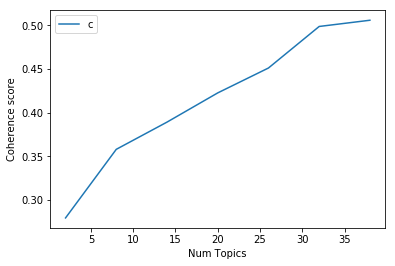

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.069*"population" + 0.032*"datum" + 0.031*"effect" + 0.031*"forest" + '
  '0.031*"model" + 0.027*"rate" + 0.024*"individual" + 0.021*"possum" + '
  '0.021*"infectious" + 0.020*"base" + 0.020*"control" + 0.015*"reduce" + '
  '0.013*"introduce" + 0.011*"invasive" + 0.011*"term" + 0.010*"demonstrate" + '
  '0.010*"alter" + 0.010*"lead" + 0.008*"dynamic" + '
  '0.008*"bovine_tuberculosis" + 0.008*"brazil" + 0.008*"night" + '
  '0.008*"epidemic" + 0.008*"important" + 0.008*"establishment" + 0.007*"east" '
  '+ 0.007*"key" + 0.007*"chance" + 0.007*"management" + 0.007*"measure" + '
  '0.007*"survival" + 0.007*"introduction" + 0.007*"effective" + 0.006*"local" '
  '+ 0.006*"propose" + 0.006*"set" + 0.006*"indirect" + 0.006*"problem" + '
  '0.006*"apply" + 0.006*"growth"'),
 (1,
  '0.107*"tick" + 0.071*"host" + 0.043*"vector" + 0.026*"number" + '
  '0.026*"rodent" + 0.024*"distribution" + 0.022*"chigger" + 0.019*"ixode" + '
  '0.019*"feed" + 0.018*"bear" + 0.017*"nymph" + 0.016*"infes

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.3525,"infection, spp, rat, pattern, result, mouse, z...",[A number of parasitic diseases have gained im...
1,1,7.0,0.4128,"human, risk, rodent, test, trap, antibody, vee...","[All great apes build nightly a structure (""ne..."
2,2,2.0,0.2536,"identify, ecology, cruzi, associate, genotype,...",[An active Trypanosoma cruzi transmission cycl...
3,3,4.0,0.1447,"infection, spp, rat, pattern, result, mouse, z...",[Animals often suffer from multiple parasite a...
4,4,2.0,0.3863,"identify, ecology, cruzi, associate, genotype,...","[Astroviruses are small, non-enveloped, positi..."
5,5,2.0,0.4459,"identify, ecology, cruzi, associate, genotype,...",[Background: Chagas disease is a systemic path...
6,6,8.0,0.4575,"host, pathogen, reservoir, important, transmis...",[Background: Emerging bacterial zoonoses in ba...
7,7,3.0,0.4544,"mammal, sample, collect, detect, site, isolate...",[Background: Mycobacterium ulcerans is the cau...
8,8,2.0,0.5269,"identify, ecology, cruzi, associate, genotype,...","[Background: Trypanosoma cruzi, the agent of C..."
9,9,7.0,0.5259,"human, risk, rodent, test, trap, antibody, vee...",[BackgroundNeurotropic arboviral infections ar...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"infection, spp, rat, pattern, result, mouse, z...",4.0,0.0533
1,7.0,"human, risk, rodent, test, trap, antibody, vee...",13.0,0.1733
2,2.0,"identify, ecology, cruzi, associate, genotype,...",8.0,0.1067
3,4.0,"infection, spp, rat, pattern, result, mouse, z...",9.0,0.1200
4,2.0,"identify, ecology, cruzi, associate, genotype,...",6.0,0.0800
5,2.0,"identify, ecology, cruzi, associate, genotype,...",5.0,0.0667
6,8.0,"host, pathogen, reservoir, important, transmis...",4.0,0.0533
7,3.0,"mammal, sample, collect, detect, site, isolate...",5.0,0.0667
8,2.0,"identify, ecology, cruzi, associate, genotype,...",6.0,0.0800
9,7.0,"human, risk, rodent, test, trap, antibody, vee...",6.0,0.0800


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      14.482419        1       1  0.132342 -0.051553
8      13.227505        1       2  0.051834 -0.004286
7      11.092485        1       3  0.054728  0.034210
2       9.897283        1       4 -0.175657 -0.097237
9       9.605887        1       5 -0.008318  0.118037
11      9.112366        1       6 -0.040485 -0.087279
5       9.034991        1       7  0.081842 -0.027121
6       8.576146        1       8  0.061784 -0.067987
0       7.427288        1       9 -0.047462  0.122452
10      3.805215        1      10 -0.017914 -0.006014
1       3.673782        1      11 -0.029761  0.056295
4       0.064639        1      12 -0.062933  0.010484, topic_info=     Category        Freq          Term       Total  loglift  logprob
2358  Default  137.000000          host  137.000000  30.0000  30.0000
1865  Default   87.000000          tick   87.000000  29.0000  29.0000
2139  Default   22.000000           dog   22.000000  28.0000  28.0000
2507  Default   21.000000      squirrel   21.000000  27.0000  27.0000
1783  Default   25.000000           red   25.000000  26.0000  26.0000
1001  Default   14.000000     community   14.000000  25.0000  25.0000
767   Default   17.000000           bat   17.000000  24.0000  24.0000
2448  Default   13.000000      mongoose   13.000000  23.0000  23.0000
2267  Default   52.000000      pathogen   52.000000  22.0000  22.0000
2328  Default   17.000000       chigger   17.000000  21.0000  21.0000
1734  Default   23.000000           rat   23.000000  20.0000  20.0000
129   Default   17.000000       density   17.000000  19.0000  19.0000
1284  Default   18.000000        coyote   18.000000  18.0000  18.0000
1721  Default    9.000000    salmonella    9.000000  17.0000  17.0000
2075  Default   38.000000        vector   38.000000  16.0000  16.0000
494   Default    9.000000          madv    9.000000  15.0000  15.0000
2007  Default   18.000000    bartonella   18.000000  14.0000  14.0000
570   Default   11.000000          veev   11.000000  13.0000  13.0000
946   Default   14.000000         nymph   14.000000  12.0000  12.0000
706   Default   13.000000           tbe   13.000000  11.0000  11.0000
1303  Default   18.000000        forest   18.000000  10.0000  10.0000
501   Default   14.000000      borrelia   14.000000   9.0000   9.0000
1345  Default    9.000000  mycobacteria    9.000000   8.0000   8.0000
307   Default   86.000000        mammal   86.000000   7.0000   7.0000
2150  Default   30.000000  transmission   30.000000   6.0000   6.0000
182   Default   15.000000         cruzi   15.000000   5.0000   5.0000
1509  Default   12.000000        possum   12.000000   4.0000   4.0000
730   Default   18.000000         urban   18.000000   3.0000   3.0000
2151  Default   39.000000        animal   39.000000   2.0000   2.0000
2393  Default   18.000000       isolate   18.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
2419  Topic12    0.002950        colony   11.453931  -0.9203  -7.6499
165   Topic12    0.002933          case   13.213347  -1.0688  -7.6556
574   Topic12    0.002823          gray    8.653539  -0.6840  -7.6939
2267  Topic12    0.003262      pathogen   52.663486  -2.3453  -7.5494
2151  Topic12    0.003182        animal   39.868813  -2.0918  -7.5742
538   Topic12    0.002965          lyme   19.053473  -1.4240  -7.6447
1865  Topic12    0.003285          tick   87.066986  -2.8409  -7.5422
831   Topic12    0.002891           fox   15.861665  -1.2658  -7.6698
1793  Topic12    0.002527    tularensis    2.592349   0.4109  -7.8045
2579  Topic12    0.002892         model   18.516911  -1.4205  -7.6698
307   Topic12    0.003153        mammal   86.347656  -2.8736  -7.5832
1196  Topic12    0.002728       ulceran    7.879316  -0.6243  -7.7280
1864  Topic12    0.002784       primate   11.705463  -0.9998  -7.7076
1441  Topic12    0.002886         range   25.368944

In [38]:
import dill

In [39]:
dill.dump_session('databases/BarbaraDataJournal.db')